In [71]:
# Packages. Written in Python 3.9.6 
print(sys.version)
import numpy as np
import seaborn as sns
import sys, re, glob
import matplotlib as mpl
import matplotlib.pyplot as plt

# Figure parameters
sns.set()
sns.set_style("whitegrid", {'axes.grid' : False})
sys.path.append('../') 
# Update plotting parameters
params = {'legend.fontsize': 'xx-large',         
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large',
          'font.sans-serif': "Arial",
          'font.family': "sans-serif",
          'figure.figsize': (6, 6),
         }
sns.set_style("whitegrid", {'axes.grid' : False})
plt.rcParams.update(params)
font = {'family' : 'sans-serif',
        'size'   : 14}
mpl.rc('font', **font)

3.9.6 | packaged by conda-forge | (default, Jul  6 2021, 08:54:05) 
[Clang 11.1.0 ]


In [72]:
def read_single_file(data_file):    
    return np.load(data_file, allow_pickle = True)

def symmetrize(M, sizes):    
    ## For triangular sweep: fills map with symmetry (here C4v)
    # First, fill other half of array (which is empty) with pi/4 mirror symmetry
    M0 = M[:] #Makes a copy 
    for ii in range(np.shape(M)[1]):
        for jj in range(np.shape(M)[2]):
            if np.all(M0[:,ii,jj,:] == 0):
                # C_{4v} symmetry enforced here: pay attention to (x,y) permutation! 
                M0[:,ii,jj,0] = M0[:,jj,ii,1]
                M0[:,ii,jj,1] = M0[:,jj,ii,0]

    # Then concatenate copies of LDOS0
    new_sizes = list(sizes)
    new_sizes[1] = 2*sizes[1]
    new_sizes[2] = 2*sizes[2]
    new_sizes = tuple(new_sizes)
    M_sym = np.zeros(new_sizes)
    for ii in range(np.shape(M_sym)[1]):
        ii0 = int(np.abs(ii - np.shape(M)[1] + 0.5))
        for jj in range(np.shape(M_sym)[2]):
            jj0 = int(np.abs(jj - np.shape(M)[2] + 0.5))
            M_sym[:,ii,jj,:] = M0[:,ii0,jj0,:]             
    M_sym = np.delete(M_sym, new_sizes[1]//2, axis = 1) # removes 0 angle that is counted twice otherwise
    M_sym = np.delete(M_sym, new_sizes[2]//2, axis = 2)    
    return M_sym

def process_data_file(file_name, extension_flag = True):    
    if extension_flag:
        data = read_single_file(folder_name + file_name)
    else:
        data = read_single_file(file_name)
    wl_vec = data.item().get("wl_vec")
    etch_rad = data.item().get("etch_rad")
    etch_depth = data.item().get("etch_depth")    
    args = data.item().get("args")

    data_mat = data.item().get("data_mat") 
    R_mat = data.item().get("R_mat") 
    T_mat = data.item().get("T_mat") 
    loss = data.item().get("loss") 
    theta_mat = data.item().get("theta_mat") 
    theta_mat = np.repeat(theta_mat[np.newaxis,:,:],np.shape(R_mat)[0], axis = 0)
    theta_mat = np.repeat(theta_mat[:,:,:,np.newaxis],np.shape(R_mat)[3], axis = 3)

    data_matsym = symmetrize(data_mat, np.shape(data_mat))
    R_matsym = symmetrize(R_mat, np.shape(R_mat))    
    T_matsym = symmetrize(T_mat, np.shape(T_mat))     
    theta_matsym = symmetrize(theta_mat, np.shape(theta_mat))    
    factor_matsym = np.divide(np.sin(theta_matsym), theta_matsym, out=np.ones_like(theta_matsym), where=theta_matsym!=0)
    
    # Average over angle and plot as a function of meas_depth
    num_angles = len(np.where(data_matsym[100, :, :, 0] != 0.)[0])
    data_matavg = np.squeeze(np.sum(np.sum(data_matsym*factor_matsym,1),1))/num_angles
    R_matavg = np.squeeze(np.sum(np.sum(R_matsym,1),1))/num_angles    
    T_matavg = np.squeeze(np.sum(np.sum(T_matsym,1),1))/num_angles        
    return data_matsym, data_matavg, R_matsym, R_matavg, T_matsym, T_matavg, wl_vec, loss, factor_matsym, theta_matsym

# Figure 4 analysis (20 microns sample)

In [73]:
folder_name = "../res/FIB_expt3/A1_20/final" # dose A, small area, 20 um thick 
expt_enhanc = 9.06
data0 = read_single_file(glob.glob(folder_name + "/*.npy")[0]) # Takes any file for reference 

wl_vec_ref = data0.item().get("wl_vec")
pol_vec = {"s", "p"}
theta_vec = data0.item().get("theta_vec")
theta_mat = data0.item().get("theta_mat")
phi_mat = data0.item().get("phi_mat")
rad_etch = data0.item().get("rad_etch")

In [74]:
# Reference simulation (unpatterned)
width = 0.080
sig = width / 2.355
wl0 = 0.550
epsi = 1.0 * np.exp(-np.divide(np.square(wl_vec_ref-wl0),2.*sig**2.))

data_matsym_ref, data_matavg_ref, R_matsym_ref, R_matavg_ref, T_matsym_ref, T_matavg_ref, wl_vec, loss, _, _  = process_data_file(glob.glob(folder_name + "/*.npy")[0], extension_flag=False)

In [75]:
file_list = []
for file in glob.glob(folder_name + "/*.npy"):
    file_name = re.split(folder_name, file)[1]
    file_list.append(file_name)
    if re.findall("radius0.0", file_name):
        data_matsym, data_matavg, R_matsym, R_matavg, T_matsym, T_matavg, wl_vec, loss, _, _= process_data_file(file_name)
        scintref = np.trapz(data_matavg[:,0]*epsi, x = wl_vec*1e3)

In [76]:
scint_yield_enhanc_list = []
loss_list = []
L_list = [] 

# Calculates enhancement from all simulations in folder
for file in file_list:
    data_matsym, data_matavg, R_matsym, R_matavg, T_matsym, T_matavg, wl_vec, loss, _, _= process_data_file(file)    
    scint_yield = np.trapz(data_matavg[:,0]*epsi, x = wl_vec*1e3)
    scint_yield_enhanc_list.append(scint_yield/scintref)
    
    print("Scintillation yield {0} = {1} (enhancement = {2})".format(file, scint_yield, scint_yield/scintref))
    L_float = re.findall("depth_(\d+).(\d)", file)[0]
    L_list.append(float(L_float[0])+float(L_float[1])/10.)
    loss_list.append(loss)    

scint_yield_enhanc_list = np.array(scint_yield_enhanc_list)
L_list = np.array(L_list)
ind_best_fit = np.where(np.abs(scint_yield_enhanc_list-expt_enhanc)==np.min(np.abs(scint_yield_enhanc_list-expt_enhanc)))
print("Etch depth fitting expt = {0}nm".format(L_list[ind_best_fit][0]))
print("Corresponding enhanc. = x{0}".format(scint_yield_enhanc_list[0]))

Scintillation yield /rcwa_YAG_20.0um_design_L_430.0nm_etch_depth_40.0nm_radius215.0nm_nG_51_loss_1e-06.npy = 0.02009049398677793 (enhancement = 8.195327762789201)
Scintillation yield /rcwa_YAG_20.0um_design_L_430.0nm_etch_depth_50.0nm_radius215.0nm_nG_51_loss_1e-06.npy = 0.023248419861283287 (enhancement = 9.483511000553118)
Scintillation yield /rcwa_YAG_20.0um_design_L_430.0nm_etch_depth_60.0nm_radius215.0nm_nG_51_loss_1e-06.npy = 0.024867483081138307 (enhancement = 10.143960353571577)
Scintillation yield /rcwa_YAG_20.0um_design_L_430.0nm_etch_depth_50.0nm_radius0.0nm_nG_51_loss_1e-06.npy = 0.0024514570458058563 (enhancement = 1.0)
Etch depth fitting expt = 50.0nm
Corresponding enhanc. = x8.195327762789201


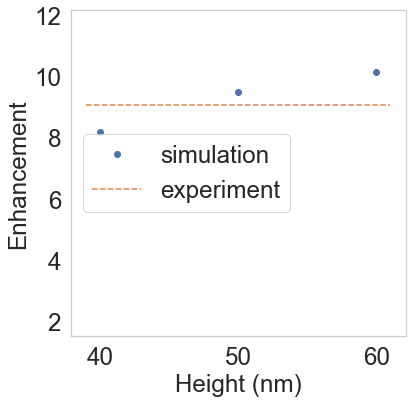

In [77]:
# Plots enhancement experiment vs. simulation
plt.figure()
plt.plot(L_list, scint_yield_enhanc_list, 'o', label = "simulation")
plt.plot(plt.xlim(), [expt_enhanc, expt_enhanc],'--', label = "experiment")
plt.ylim([1.5, np.max(scint_yield_enhanc_list)*1.2])
plt.xlabel("Height (nm)")
plt.ylabel("Enhancement")
plt.legend()

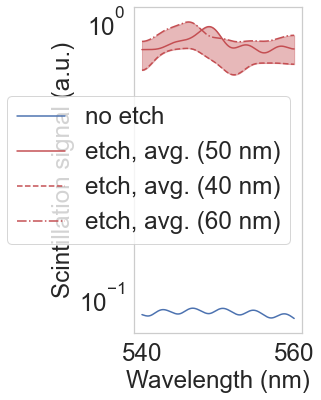

In [78]:
## For 20 microns experiment
# Spectral enhancement plot 
from scipy.ndimage import gaussian_filter1d

plt.figure(figsize = (3,6))
file = "/rcwa_YAG_20.0um_design_L_430.0nm_etch_depth_60.0nm_radius215.0nm_nG_51_loss_1e-06.npy"
data_matsym, data_matavg, R_matsym, R_matavg, T_matsym, T_matavg, wl_vec, loss, _, _ = process_data_file(file)
epsi = 1.0 * np.exp(-np.divide(np.square(wl_vec-wl0),2.*sig**2.))
wl_range = np.arange(0,len(wl_vec))
pstd_enhancement = data_matavg[wl_range,0]*epsi
normalization = np.max(gaussian_filter1d(pstd_enhancement,100))
pstd_enhancement = pstd_enhancement/normalization

file = "/rcwa_YAG_20.0um_design_L_430.0nm_etch_depth_50.0nm_radius0.0nm_nG_51_loss_1e-06.npy"
data_matsym, data_matavg, R_matsym, R_matavg, T_matsym, T_matavg, wl_vec, loss, _, _= process_data_file(file)
off_pattern = data_matavg[wl_range,0]*epsi/normalization

file = "/rcwa_YAG_20.0um_design_L_430.0nm_etch_depth_50.0nm_radius215.0nm_nG_51_loss_1e-06.npy"
data_matsym, data_matavg, R_matsym, R_matavg, T_matsym, T_matavg, wl_vec, loss, _, _ = process_data_file(file)
mean_enhancement = data_matavg[wl_range,0]*epsi/normalization

file = "/rcwa_YAG_20.0um_design_L_430.0nm_etch_depth_40.0nm_radius215.0nm_nG_51_loss_1e-06.npy"
data_matsym, data_matavg, R_matsym, R_matavg, T_matsym, T_matavg, wl_vec, loss, _, _ = process_data_file(file)
mstd_enhancement = data_matavg[wl_range,0]*epsi/normalization

# Uncomment line with raw data if needed
plt.semilogy(wl_vec[wl_range]*1e3, gaussian_filter1d(off_pattern, 1), label = 'no etch') # Unpatterned

plt.semilogy(wl_vec[wl_range]*1e3, gaussian_filter1d(mean_enhancement,100), label = 'etch, avg. (50 nm)', color = 'r') # Patterned, 50 nm etch depth
# plt.semilogy(wl_vec[wl_range]*1e3, mean_enhancement, 'r', label = 'etch (raw)', alpha = 0.5)

plt.semilogy(wl_vec[wl_range]*1e3, gaussian_filter1d(mstd_enhancement,100), '--', label = 'etch, avg. (40 nm)', color = 'r') # Patterned, 40 nm etch depth
# plt.semilogy(wl_vec[wl_range]*1e3, mstd_enhancement, 'r--', label = 'etch (raw)', alpha = 0.5)

plt.semilogy(wl_vec[wl_range]*1e3, gaussian_filter1d(pstd_enhancement,100), '-.', label = 'etch, avg. (60 nm)', color = 'r') # Patterned, 60 nm etch depth
# plt.semilogy(wl_vec[wl_range]*1e3, pstd_enhancement, 'r-.', label = 'etch (raw)', alpha = 0.5)

plt.fill_between(wl_vec[wl_range]*1e3, np.maximum(gaussian_filter1d(pstd_enhancement,100), gaussian_filter1d(mean_enhancement,100)), 
gaussian_filter1d(mstd_enhancement,100), color = 'r', alpha = 0.4)
plt.ylabel('Scintillation signal (a.u.)')
plt.xlabel('Wavelength (nm)')
plt.legend()

# 50 microns sample (Used for Figure 5 measurement -- Enhancement plot shown in the SI)
Many variables are shared with first part of notebook, so be careful when re-running cells 

In [79]:
folder_name = "../res/FIB_expt3/A2_50/final" # dose A, large area, 50 um thick (July sample)
expt_enhanc = 2.31
data0 = read_single_file(glob.glob(folder_name + "/*.npy")[0]) # Takes any file for reference 

wl_vec_ref = data0.item().get("wl_vec")
pol_vec = {"s", "p"}
theta_vec = data0.item().get("theta_vec")
theta_mat = data0.item().get("theta_mat")
phi_mat = data0.item().get("phi_mat")
rad_etch = data0.item().get("rad_etch")
data_matsym_ref, data_matavg_ref, R_matsym_ref, R_matavg_ref, T_matsym_ref, T_matavg_ref, wl_vec, loss, _, _  = process_data_file(glob.glob(folder_name + "/*.npy")[0], extension_flag=False)

In [80]:
file_list = []
for file in glob.glob(folder_name + "/*.npy"):
    file_name = re.split(folder_name, file)[1]
    file_list.append(file_name)
    if re.findall("radius0.0", file_name):
        data_matsym, data_matavg, R_matsym, R_matavg, T_matsym, T_matavg, wl_vec, loss, _, _= process_data_file(file_name)
        scintref = np.trapz(data_matavg[:,0]*epsi, x = wl_vec*1e3)

In [81]:
scint_yield_enhanc_list = []
loss_list = []
L_list = [] 
for file in file_list:
    data_matsym, data_matavg, R_matsym, R_matavg, T_matsym, T_matavg, wl_vec, loss, _, _= process_data_file(file)    
    scint_yield = np.trapz(data_matavg[:,0]*epsi, x = wl_vec*1e3)
    scint_yield_enhanc_list.append(scint_yield/scintref)
    
    print("Scintillation yield {0} = {1} (enhancement = {2})".format(file, scint_yield, scint_yield/scintref))
    L_float = re.findall("depth_(\d+).(\d)", file)[0]
    L_list.append(float(L_float[0])+float(L_float[1])/10.)
    loss_list.append(loss)    
scint_yield_enhanc_list = np.array(scint_yield_enhanc_list)
L_list = np.array(L_list)
ind_best_fit = np.where(np.abs(scint_yield_enhanc_list-expt_enhanc)==np.min(np.abs(scint_yield_enhanc_list-expt_enhanc)))

Scintillation yield /rcwa_YAG_50.0um_design_L_430.0nm_etch_depth_34.0nm_radius0.0nm_nG_51_loss_1e-06.npy = 0.0061237136873940595 (enhancement = 1.0)
Scintillation yield /rcwa_YAG_50.0um_design_L_430.0nm_etch_depth_44.0nm_radius215.0nm_nG_51_loss_1e-06.npy = 0.047864597737078574 (enhancement = 7.816269698501745)
Scintillation yield /rcwa_YAG_50.0um_design_L_430.0nm_etch_depth_34.0nm_radius215.0nm_nG_51_loss_1e-06.npy = 0.04046184648248137 (enhancement = 6.607403374487267)
Scintillation yield /rcwa_YAG_50.0um_design_L_430.0nm_etch_depth_24.0nm_radius215.0nm_nG_51_loss_1e-06.npy = 0.03266536547253876 (enhancement = 5.334241138638125)


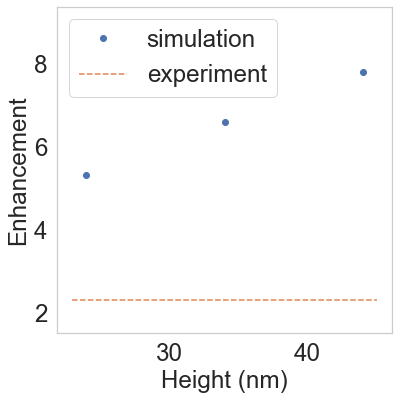

In [82]:
# Plots enhancement experiment vs. simulation
plt.figure()
plt.plot(L_list, scint_yield_enhanc_list, 'o', label = "simulation")
plt.plot(plt.xlim(), [expt_enhanc, expt_enhanc],'--', label = "experiment")
plt.ylim([1.5, np.max(scint_yield_enhanc_list)*1.2])
plt.xlabel("Height (nm)")
plt.ylabel("Enhancement")
plt.legend()

Text(0.5, 0, 'Wavelength (nm)')

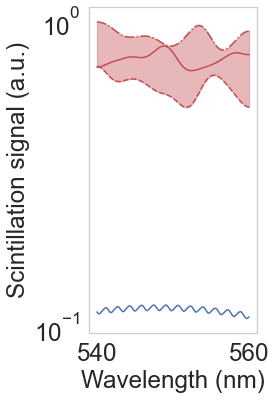

In [83]:
## For 50 microns experiment
# Spectral enhancement plot 
from scipy.ndimage import gaussian_filter1d

plt.figure(figsize = (3,6))
file = "/rcwa_YAG_50.0um_design_L_430.0nm_etch_depth_44.0nm_radius215.0nm_nG_51_loss_1e-06.npy"
data_matsym, data_matavg, R_matsym, R_matavg, T_matsym, T_matavg, wl_vec, loss, _, _ = process_data_file(file)
epsi = 1.0 * np.exp(-np.divide(np.square(wl_vec-wl0),2.*sig**2.))
wl_range = np.arange(0,len(wl_vec))
pstd_enhancement = data_matavg[wl_range,0]*epsi
normalization = np.max(gaussian_filter1d(pstd_enhancement,100))
pstd_enhancement = pstd_enhancement/normalization

file = "/rcwa_YAG_50.0um_design_L_430.0nm_etch_depth_34.0nm_radius0.0nm_nG_51_loss_1e-06.npy"
data_matsym, data_matavg, R_matsym, R_matavg, T_matsym, T_matavg, wl_vec, loss, _, _= process_data_file(file)
off_pattern = data_matavg[wl_range,0]*epsi/normalization

file = "/rcwa_YAG_50.0um_design_L_430.0nm_etch_depth_34.0nm_radius215.0nm_nG_51_loss_1e-06.npy"
data_matsym, data_matavg, R_matsym, R_matavg, T_matsym, T_matavg, wl_vec, loss, _, _ = process_data_file(file)
mean_enhancement = data_matavg[wl_range,0]*epsi/normalization

file = "/rcwa_YAG_50.0um_design_L_430.0nm_etch_depth_24.0nm_radius215.0nm_nG_51_loss_1e-06.npy"
data_matsym, data_matavg, R_matsym, R_matavg, T_matsym, T_matavg, wl_vec, loss, _, _ = process_data_file(file)
mstd_enhancement = data_matavg[wl_range,0]*epsi/normalization

# Uncomment line with raw data if needed
plt.semilogy(wl_vec[wl_range]*1e3, gaussian_filter1d(off_pattern, 1), label = 'no etch') # unpatterned

plt.semilogy(wl_vec[wl_range]*1e3, gaussian_filter1d(mean_enhancement,100), label = 'etch, avg. (34 nm)', color = 'r') # Patterned, 34 nm etch depth
# plt.semilogy(wl_vec[wl_range]*1e3, mean_enhancement, 'r', label = 'etch (raw, 34 nm)', alpha = 0.5)

plt.semilogy(wl_vec[wl_range]*1e3, gaussian_filter1d(mstd_enhancement,100), '--', label = 'etch, avg. (24 nm)', color = 'r') # Patterned, 24 nm etch depth
# plt.semilogy(wl_vec[wl_range]*1e3, mstd_enhancement, 'r--', label = 'etch (raw, 24 nm)', alpha = 0.5)

plt.semilogy(wl_vec[wl_range]*1e3, gaussian_filter1d(pstd_enhancement,100), '-.', label = 'etch, avg. (44 nm)', color = 'r') # Patterned, 44 nm etch depth
# plt.semilogy(wl_vec[wl_range]*1e3, pstd_enhancement, 'r-.', label = 'etch (raw, 44 nm)', alpha = 0.5)

plt.fill_between(wl_vec[wl_range]*1e3, np.maximum(gaussian_filter1d(pstd_enhancement,100), gaussian_filter1d(mean_enhancement,100)), 
gaussian_filter1d(mstd_enhancement,100), color = 'r', alpha = 0.4)
plt.ylabel('Scintillation signal (a.u.)')
plt.xlabel('Wavelength (nm)')
# plt.legend()